# CIFAR-10 Image Classification

## Table of Contents
- [Introduction](#introduction)
- [Import the dataset](#import-the-dataset)
- [Investigate and preprocess the dataset](#investigate-and-preprocess-the-dataset)
- [Evaluating model performance](#evaluating-model-performance)
- [Build a simple neural network](#build-a-simple-neural-network)

## Introduction <a class="anchor" id="introduction"></a>

In [75]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, clone_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import numpy as np

## Import the dataset <a class="anchor" id="import-the-dataset"></a>

Import the CIFAR-10 dataset from Keras using the load_data function and one-hot encode the labels

In [76]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

## Investigate and preprocess the dataset <a class="anchor" id="investigate-and-preprocess-the-dataset"></a>

Investigate the properties of the training and test data

In [77]:
print(f"Number of training data rows: {x_train.shape[0]}")
print(f"Number of test data rows: {x_test.shape[0]}")
print(f'Resolution of each image: {x_train.shape[1]} x {x_train.shape[2]}')
print(f'Number of channels: {x_train.shape[3]}')
print(f'Number of classes: {len(np.unique(y_train))}')

Number of training data rows: 50000
Number of test data rows: 10000
Resolution of each image: 32 x 32
Number of channels: 3
Number of classes: 2


We can see that there are 50,000 training images and 10,000 test images meaning that the dataset is split into ~83% training and ~17% test data. Each image is 32x32 pixels with 3 channels (RGB).

In order to effectively compare the models, we need to create a validation set. In this case, we will take 20% of the training set as the validation set and use stratification to ensure that the classes are evenly distributed between the training and validation sets.

In [78]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, stratify=y_train)

Display an image corresponding to each of the 10 classes using matplotlib

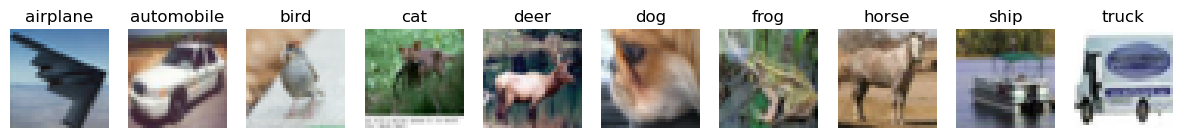

In [79]:
target_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

figure, axis = plt.subplots(1, 10, figsize=(15, 1.5))
for i in range(len(target_names)):
    index = np.argmax(y_train, axis=1) == i
    index = np.argmax(index)
    axis[i].imshow(x_train[index])
    axis[i].set_title(target_names[i])
    axis[i].axis('off')
plt.show()

As the images use the RGB colour model, the pixel values for each image are positive integers in the range of [0,255]. Therefore, we need to normalise the pixel values into the range of [0,1].

In [80]:
x_train, x_val, x_test = x_train / 255.0, x_val / 255.0, x_test / 255.0

## Evaluating model performance <a class="anchor" id="evaluating-model-performance"></a>

Create a function to display the accuracy and loss of the model over the training and validation sets

In [81]:
colours = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']


def plot_training_accuracy_loss(history, keys=None):
    if keys:
        assert(len(history) == len(keys))
    # Plot training & validation accuracy values
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    for i, h in enumerate(history):
        colour = colours[i % len(colours)]
        axs[0].plot(h.history['accuracy'], label=f'Training Accuracy ({keys[i] if keys else ""})', color=colour)
        axs[0].plot(h.history['val_accuracy'], label=f'Validation Accuracy ({keys[i] if keys else ""})', color=colour, linestyle='--')
        axs[1].plot(h.history['loss'], label=f'Training Loss ({keys[i] if keys else ""})', color=colour)
        axs[1].plot(h.history['val_loss'], label=f'Validation Loss ({keys[i] if keys else ""})', color=colour, linestyle='--')
    axs[0].set_title('Model Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Accuracy')
    axs[0].legend(loc='upper left')
    axs[1].set_title('Model Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Loss')
    axs[1].legend(loc='lower left')
    plt.show()

Create a function to display the confusion matrix of the model

In [82]:
def confusion_matrix(model):
    # Predict the labels of the test set
    predictions = model.predict(x_test, verbose=0)
    # Convert the one-hot encoded predictions and labels into single integers
    predictions = np.argmax(predictions, axis=1)
    true_labels = np.argmax(y_test, axis=1)
    # Create a confusion matrix
    cm = tf.math.confusion_matrix(true_labels, predictions)
    # Plot the confusion matrix
    plt.figure(figsize=(5, 5))
    plt.imshow(cm, cmap=plt.cm.Blues)
    plt.xlabel("Predicted labels")
    plt.ylabel("True labels")
    plt.xticks(np.arange(10))
    plt.yticks(np.arange(10))
    plt.title("Confusion Matrix")
    plt.colorbar()
    plt.show()

Create a function to calculate the accuracy and loss of the model on the test set

In [83]:
def test_model(model):
    # Evaluate the model on the test set
    test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
    print(f'Test accuracy: {test_acc}')
    print(f'Test loss: {test_loss}')
    # Create a confusion matrix
    confusion_matrix(model)

## Evaluating hyperparameter performance <a class="anchor" id="evaluating-hyperparameter-performance"></a>

Create a function to evaluate the performance of a model with different activation functions

In [84]:
def evaluate_activation_functions(model):
    activation_functions = [tf.keras.activations.relu, tf.keras.activations.sigmoid, tf.keras.activations.tanh]
    history = []
    for activation_function in activation_functions:
        # Clone the model
        new_model = clone_model(model)
        # Replace the activation function in each model layer except the output layer
        for layer in new_model.layers[:-1]:
            # If the layer is a convolutional layer or a fully connected layer, replace the activation function
            if layer.__class__.__name__ == 'Conv2D' or layer.__class__.__name__ == 'Dense':
                layer.activation = activation_function
        # Compile the model
        new_model.compile(optimizer='adam',
                          loss='categorical_crossentropy',
                          metrics=['accuracy'])
        # Train the model and append the history
        history.append(new_model.fit(x_train, y_train, epochs=20, validation_data=(x_val, y_val), verbose=0))

    # Plot the accuracy and loss of the models
    plot_training_accuracy_loss(history, keys=['ReLU', 'Sigmoid', 'Tanh'])

    return history

Create a function to evaluate the performance of a model with different optimisers

In [85]:
def evaluate_optimisers(model):
    optimisers = [tf.keras.optimizers.Adam(), tf.keras.optimizers.SGD(), tf.keras.optimizers.RMSprop()]
    history = []
    for optimiser in optimisers:
        # Clone the model
        new_model = clone_model(model)
        # Compile the model
        new_model.compile(optimizer=optimiser,
                          loss='categorical_crossentropy',
                          metrics=['accuracy'])
        # Train the model and append the history
        history.append(new_model.fit(x_train, y_train, epochs=20, validation_data=(x_val, y_val), verbose=0))

    # Plot the accuracy and loss of the models
    plot_training_accuracy_loss(history, keys=['Adam', 'SGD', 'RMSprop'])

    return history

Create a function to evaluate the performance of a model with different learning rates

In [86]:
def evaluate_learning_rates(model):
    learning_rates = [0.0001, 0.001, 0.01]
    history = []
    for learning_rate in learning_rates:
        # Clone the model
        new_model = clone_model(model)
        # Compile the model
        new_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                          loss='categorical_crossentropy',
                          metrics=['accuracy'])
        # Train the model and append the history
        history.append(new_model.fit(x_train, y_train, epochs=20, validation_data=(x_val, y_val), verbose=0))

    # Plot the accuracy and loss of the models
    plot_training_accuracy_loss(history, keys=['lr=0.0001', 'lr=0.001', 'lr=0.01'])

    return history

Create a function to evaluate the performance of a model with different convolutional kernel sizes

In [87]:
def evaluate_kernel_sizes(model):
    kernel_sizes = [3, 5, 7]
    history = []
    for kernel_size in kernel_sizes:
        # Clone the model
        new_model = clone_model(model)
        # Replace the kernel size in each convolutional layer
        for layer in new_model.layers[:-1]:
            # If the layer is a convolutional layer, replace the kernel size
            if layer.__class__.__name__ == 'Conv2D':
                layer.kernel_size = (kernel_size, kernel_size)
        # Compile the model
        new_model.compile(optimizer='adam',
                          loss='categorical_crossentropy',
                          metrics=['accuracy'])
        # Train the model and append the history
        history.append(new_model.fit(x_train, y_train, epochs=20, validation_data=(x_val, y_val), verbose=0))

    # Plot the accuracy and loss of the models
    plot_training_accuracy_loss(history, keys=['3x3', '5x5', '7x7'])

    return history

Create a function to evaluate the performance of a model with different numbers of convolutional filters

In [88]:
def evaluate_num_of_filters(model, custom_model=None, custom_filters=None):
    num_of_filters = [32, 64, 128]
    history = []
    for filter_num in num_of_filters:
        # Clone the model
        new_model = clone_model(model)
        # Replace the number of filters in each convolutional layer
        for layer in new_model.layers[:-1]:
            # If the layer is a convolutional layer, replace the layer with a new layer with the new number of filters
            if layer.__class__.__name__ == 'Conv2D':
                new_model.layers[new_model.layers.index(layer)] = Conv2D(filters=filter_num, kernel_size=layer.kernel_size, activation=layer.activation,
                                                                         padding=layer.padding)(layer.input)
        # Compile the model
        new_model.compile(optimizer='adam',
                          loss='categorical_crossentropy',
                          metrics=['accuracy'])
        # Train the model and append the history
        history.append(new_model.fit(x_train, y_train, epochs=20, validation_data=(x_val, y_val), verbose=0))

    # If a custom model is provided, train it and append the history
    if custom_model:
        custom_model.compile(optimizer='adam',
                             loss='categorical_crossentropy',
                             metrics=['accuracy'])
        history.append(custom_model.fit(x_train, y_train, epochs=20, validation_data=(x_val, y_val), verbose=0))
        # Plot the accuracy and loss of the models
        plot_training_accuracy_loss(history, keys=['32', '64', '128', str(custom_filters)])
        return history

    # Plot the accuracy and loss of the models
    plot_training_accuracy_loss(history, keys=['32 Filters', '64 Filters', '128 Filters'])
    return history

## Build a simple neural network <a class="anchor" id="simple-neural-network"></a>

Create a simple neural network consisting of a single fully connected layer as a baseline:

- The first layer is a convolutional layer with 32 filters, a kernel size of 3x3. The input shape is 32x32x3 (the 3 corresponds to the 3 channels in the RGB colour model).
- This 1D array is passed to a single fully connected layer with 10 neurons and a softmax activation function, where each neuron corresponds to a class.
- The output of the softmax activation function is a probability distribution over the 10 classes in the CIFAR-10 dataset.
- The categorical cross-entropy loss function (as the labels are one-hot encoded and this is a good choice according to [the documentation](https://keras.io/api/losses/probabilistic_losses/#categoricalcrossentropy-class))

Start by using:
- ReLU activation function (as it is a good default choice)
- Adam optimiser (as it is a good default choice)

In [89]:
single_layer_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)),
    Flatten(),
    Dense(10, activation='softmax')
])
single_layer_model.compile(optimizer='adam',
                           loss='categorical_crossentropy',
                           metrics=['accuracy']
                           )

Train the model for 100 epochs with a batch size of 64 on the training data and evaluate the model on the validation data

In [90]:
single_layer_model_history = single_layer_model.fit(x_train, y_train, batch_size=128, epochs=100,
                                                    validation_data=(x_val, y_val))

Epoch 1/100
313/313 [==============================] - 1s 3ms/step - loss: 1.5711 - accuracy: 0.4506 - val_loss: 1.3559 - val_accuracy: 0.5237
Epoch 2/100
313/313 [==============================] - 1s 3ms/step - loss: 1.2450 - accuracy: 0.5703 - val_loss: 1.2505 - val_accuracy: 0.5648
Epoch 3/100
313/313 [==============================] - 1s 3ms/step - loss: 1.1341 - accuracy: 0.6108 - val_loss: 1.2307 - val_accuracy: 0.5699
Epoch 4/100
313/313 [==============================] - 1s 3ms/step - loss: 1.0529 - accuracy: 0.6387 - val_loss: 1.2472 - val_accuracy: 0.5699
Epoch 5/100
313/313 [==============================] - 1s 3ms/step - loss: 0.9845 - accuracy: 0.6619 - val_loss: 1.1749 - val_accuracy: 0.5920
Epoch 6/100
313/313 [==============================] - 1s 3ms/step - loss: 0.9327 - accuracy: 0.6803 - val_loss: 1.1462 - val_accuracy: 0.6034
Epoch 7/100
313/313 [==============================] - 1s 3ms/step - loss: 0.8845 - accuracy: 0.6997 - val_loss: 1.1665 - val_accuracy: 0.6029

Evaluate the model by plotting the accuracy and loss over the training and validation sets

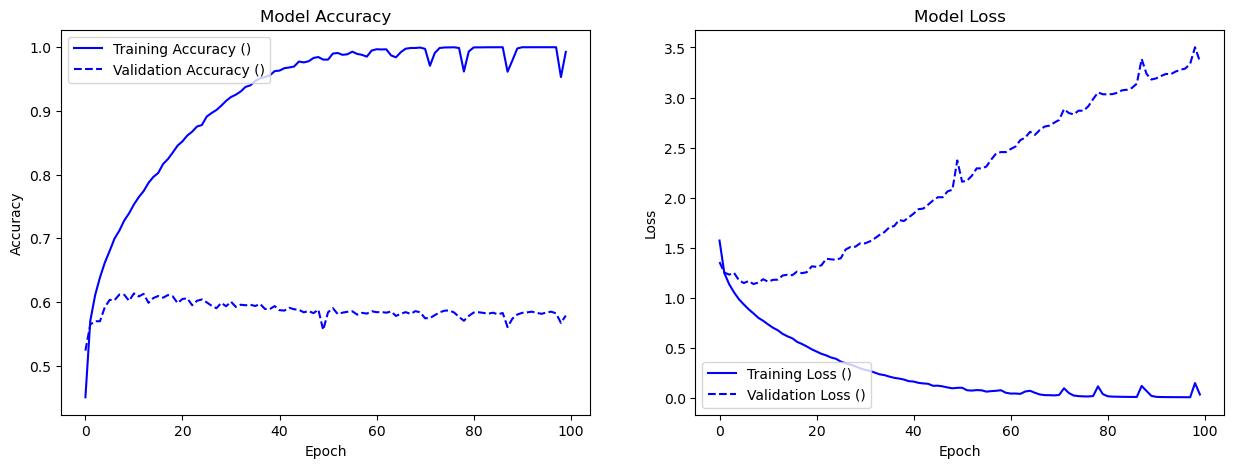

In [91]:
plot_training_accuracy_loss([single_layer_model_history])

It is clear that the model is overfitting the training data because the validation loss begins to increase after about 10 epochs and the training accuracy approaches 1.0. Later, regularisation techniques will be explored on a deep convolutional neural network to reduce overfitting. First, lets run the model on the test set and display the confusion matrix

Test accuracy: 0.567300021648407
Test loss: 3.400848388671875


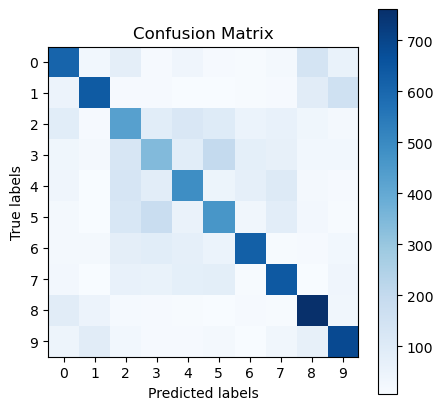

In [92]:
test_model(single_layer_model)

 The single-layer CNN showed reasonable performance with an accuracy of 56% on the testing set. The confusion matrix shows that it commonly mistook images with class 3 (cats) as class 5 (dogs) and vice versa which makes snese given they look fairly similar in 32x32 pixel images. Now we'll compare the performance of the model with different activation functions, and do an early stop after 20 epochs to reduce overfitting.

### Compare with different activation functions

In order to compare the performance of the model with different activation functions, we will create a model for each activation function and train it for 20 epochs. Then, the validation accuracy will be plotted for each model so that they can be compared.

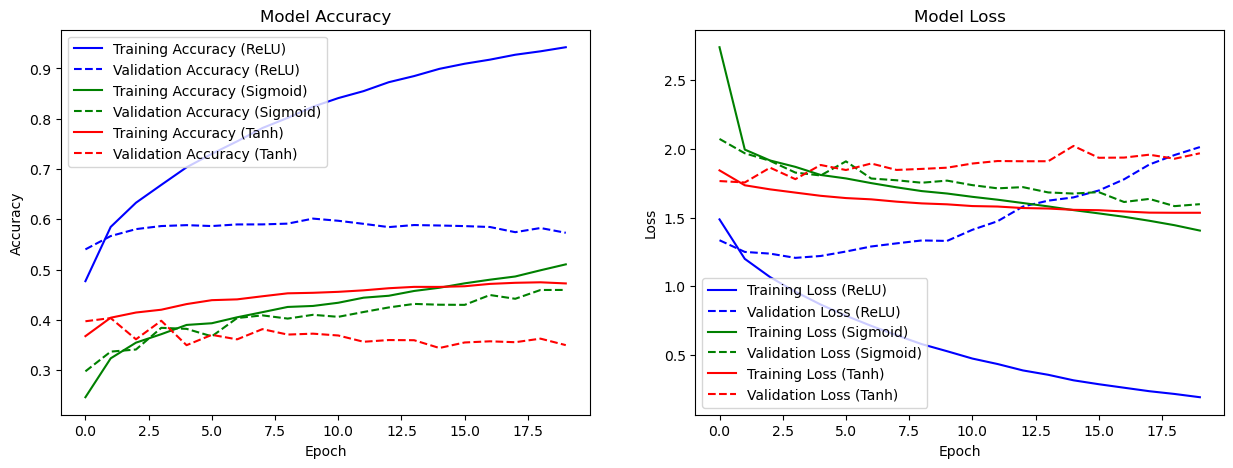

In [93]:
single_layer_model_activation_history = evaluate_activation_functions(single_layer_model)

The graph shows that the ReLU activation function performs better than the sigmoid and tanh activation functions as the validation accuracy is much higher across all epochs. ReLU is generally considered to be better than sigmoid and tanh for image classification as it's computationally efficient and avoids the vanishing gradient problem, although it will be worth performing this comparison on another models to see if ReLU is consistently the better performing activation function.

### Compare with different optimisers

In [94]:
single_layer_model_optimiser_history = evaluate_optimisers(single_layer_model)

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

This graph shows that the performance of the model is relatively similar for Adam and RMSprop, with SGD being slightly lower. Throughout the training, both Adam and RMSprop perform better than the other at some point, but the differences are not significant after the first few epochs. Therefore, the Adam optimiser will continue to be used for the rest of the comparisons with this model, although it will be worth performing this comparison on other models to see which optimiser is consistently the best.

### Compare with different learning rates

In [ ]:
single_layer_model_learning_rate_history = evaluate_learning_rates(single_layer_model)

From this graph, we can see that a learning rate of between 0.0001 and 0.001 is the best performing because the validation accuracy for these learning rates are similar, being much higher than 0.01 which performs extremely poorly. However, a learning rate closer to 0.001 may be prone to overfitting as the training accuracy is much higher than the validation accuracy, although it will be interesting to test this with another model architecture.

### Compare with different convolutional kernel sizes and number of filters

In [ ]:
single_layer_kernel_size_history = evaluate_kernel_sizes(single_layer_model)

In [ ]:
single_layer_number_of_filters_history = evaluate_num_of_filters(single_layer_model)

## Build a more complex neural network

Create a more complex neural network consisting of 3 convolutional layers with max pooling layers between them, followed by a flatten layer and 2 dense layers.

Model architecture: *TensorFlow. Convolutional Neural Networks (CNN) - TensorFlow Core. [online] Available at: https://www.tensorflow.org/tutorials/images/cnn [Accessed 6 March 2023]*.

- The first convolutional layer has 32 filters of size 3x3, whereas the second and third convolutional layers have 64 filters of size 3x3.
- The max pooling layers inbetween each convolutional layer has a pool size of 2x2.
- The output of the final convolutional layer is flattened and passed to a dense layer with 64 neurons.
- The final dense layer has 10 neurons and a softmax activation function, where each neuron corresponds to a class.

Again, start by using:
- ReLU activation function for the convolutional layers (as it is a good default choice)
- Adam optimiser (as it is a good default choice)

In [ ]:
multi_layer_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')
])
multi_layer_model.compile(optimizer='adam',
                          loss='categorical_crossentropy',
                          metrics=['accuracy']
                          )

Train the model for 100 epochs with a batch size of 64 on the training data and evaluate the model on the validation data

In [ ]:
multi_layer_model_history = multi_layer_model.fit(x_train, y_train, batch_size=64, epochs=100,
                                                  validation_data=(x_val, y_val))
plot_training_accuracy_loss([multi_layer_model_history])

In [ ]:
test_model(multi_layer_model)

As expected, this model performs much better than the single layer model, as evidenced by greater test accuracy. However, similar to the single layer model, the model is overfitting the training data. As a result, we will also do an early stop after 20 epochs to prevent the model from overfitting.

### Compare different activation functions

For this model, all the layers that use an activation function will be modified, except the final layer which must remain as softmax. The activation functions to compare are:
- ReLU
- Sigmoid
- Tanh

In [ ]:
multi_layer_model_activation_history = evaluate_activation_functions(multi_layer_model)

Similar to the simple model, ReLU is the best performing activation function

### Compare with different optimisers

In [ ]:
multi_layer_model_optimiser_history = evaluate_optimisers(multi_layer_model)

Similar to the simple model, both the Adam and RMSProp optimisers perform better than the SGD optimiser. This could be because Adam and RMSProp are adaptive optimisers meaning that they adapt the learning rate during training, whereas SGD does not. Since both Adam and RMSProp offer similar results, we will use Adam for the rest of the experiments.

### Compare with different learning rates

In [ ]:
multi_layer_model_learning_rate_history = evaluate_learning_rates(multi_layer_model)

The results seen with different learning rates on this model are similar to the results seen with the simple model - learning rates of 0.0001 and 0.001 have similar performance on the validation set by the 20th epoch, while the learning rate of 0.01 has much worse performance. This is likely due to the fact that the learning rate is too high, and the model is unable to converge to a good solution. Also similar to the simple model, a learning rate of 0.001 may overfit on the training set as the training accuracy is much higher than the validation accuracy.

### Compare with different filter sizes and number of filters

For this model, we will compare the performance of different filter sizes. The filter sizes to compare are:
- 3x3
- 5x5
- 7x7

We need to add padding to each convolutional layer to allow the larger filters to slide over the edges of images.

In [ ]:
multi_layer_model_kernel_size_history = evaluate_kernel_sizes(multi_layer_model)

These results show that 3x3 filters produce the best results. This is likely because the 3x3 filters are able to capture more local information than the larger filters, which are better at observing global patterns.

We will now compare the performance of different numbers of filters. The numbers of filters to compare are:
- 32
- 64
- 128
- Increasing the number of filters in each layer 32 -> 64 -> 128

In [ ]:
increasing_filters = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')
])

multi_layer_model_number_of_filters_history = evaluate_num_of_filters(multi_layer_model, custom_model=increasing_filters, custom_filters='32 -> 64 -> 128')

These results show that increasing the number of filters in each layer does not have much effect on the performance of the model which is likely because the model is able to learn the features it needs with 32 filters.

### Use discovered hyperparameters to train a model

Using the results from the previous experiments, we will now create the multi-layer model with the following configuration:
- activation function: ReLU
- optimiser: Adam
- learning rate: 0.0001
- filter size: 3x3
- filter numbers: 32

Since this is fairly similar to the initial multi-layer model configuration, effectively we will be testing the difference in learning rate on the multi-layer model. For consistency, it will be trained for 100 epochs.

In [ ]:
multi_layer_model_tuned = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(32, (3, 3), activation='relu'),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')
])
multi_layer_model_tuned.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                                loss='categorical_crossentropy',
                                metrics=['accuracy']
                                )

In [ ]:
multi_layer_model_tuned_history = multi_layer_model_tuned.fit(x_train, y_train, epochs=100,
                                                              validation_data=(x_val, y_val))
plot_training_accuracy_loss(multi_layer_model_tuned_history)

In [ ]:
test_model(multi_layer_model_tuned)

It is clear to see that using a learning rate of 0.0001 has improved the performance of the model as the test accuracy has increased by approximately 4% compared to the initial model. This is likely due to the fact that the learning rate is lower, and the model is able to converge to a better solution. It is also clear that the amount the model overfits on the training set has decreased as the training accuracy is now closer to the validation accuracy and the validation loss is lower.

## Build a Deep Convolutional Neural Network with VGG architecture

Since we've built a simple CNN and a more complex CNN, let's now experiment building a deep CNN using the VGG architecture which is a popular architecture for image classification. CNN's with VGG architecture consist of a stack of VGG blocks followed by a fully connected layer. A VGG block consists of 2 convolutional layers with 3x3 filters, followed by a max pooling layer with a 2x2 filter.

Architecture taken from: *Simonyan, K., & Zisserman, A. (2015). Very deep convolutional networks for large-scale image recognition. In Proceedings of the International Conference on Learning Representations (ICLR)*.

In [ ]:
# Create a function to create a VGG block with a custom number of filters
def VGGBlock(filters=32, activation='relu', input_shape=None):
    if input_shape is None:
        return Sequential([
            Conv2D(filters, (3, 3), activation=activation, padding='same'),
            Conv2D(filters, (3, 3), activation=activation, padding='same'),
            MaxPooling2D((2, 2))
        ])
    else:
        return Sequential([
            Conv2D(filters, (3, 3), activation=activation, padding='same', input_shape=input_shape),
            Conv2D(filters, (3, 3), activation=activation, padding='same'),
            MaxPooling2D((2, 2))
        ])

### Single VGG Block

The first deep CNN we will build will consist of a single VGG block. The output is flattened and passed to a Dense layer with 128 neurons and a ReLU activation function. The output is then passed to another Dense layer with 10 neurons and a softmax activation function.

In [ ]:
vgg_single_block_model = Sequential([
    VGGBlock(filters=32, activation='relu', input_shape=(32, 32, 3)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])
vgg_single_block_model.compile(optimizer='adam',
                               loss='categorical_crossentropy',
                               metrics=['accuracy'])

Train the model for 100 epochs with a batch size of 64 on the training data and evaluate the model on the validation data

In [ ]:
vgg_single_block_model_history = vgg_single_block_model.fit(x_train, y_train, batch_size=64, epochs=100,
                                                            validation_data=(x_val, y_val))
plot_training_accuracy_loss(vgg_single_block_model_history)

Evaluate the model on the test set - the expected accuracy should be much higher than the simple neural network

In [ ]:
test_model(vgg_single_block_model)

As expected, the accuracy is higher than the simple neural network. This is reflected in the confusion matrix, where the model is much better at predicting the correct class for each image (the diagonal is much lighter than the simple neural network's confusion matrix). However, the model is rapidly overfitting the validation data set after a few epochs which may be because the model is too complex for the small dataset.

### Double VGG Block

Lets try adding another VGG block with 64 filters to the model and see how it affects the accuracy.

In [ ]:
vgg_double_block_model = Sequential([
    VGGBlock(filters=32, activation='relu', input_shape=(32, 32, 3)),
    VGGBlock(filters=64, activation='relu'),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])
vgg_double_block_model.compile(optimizer='adam',
                               loss='categorical_crossentropy',
                               metrics=['accuracy'])

In [ ]:
vgg_double_block_model_history = vgg_double_block_model.fit(x_train, y_train, batch_size=64, epochs=100,
                                                            validation_data=(x_val, y_val))
plot_training_accuracy_loss(vgg_double_block_model_history)

In [ ]:
test_model(vgg_double_block_model)

The accuracy has improved by a reasonable amount over the single VGG block model, so it is plausible that adding another VGG block will improve the accuracy even further. This time, lets add a block with 128 filters.

### Triple VGG Block

In [ ]:
vgg_triple_block_model = Sequential([
    VGGBlock(filters=32, activation='relu', input_shape=(32, 32, 3)),
    VGGBlock(filters=64, activation='relu'),
    VGGBlock(filters=128, activation='relu'),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])
vgg_triple_block_model.compile(optimizer='adam',
                               loss='categorical_crossentropy',
                               metrics=['accuracy'])

In [ ]:
vgg_triple_block_model_history = vgg_triple_block_model.fit(x_train, y_train, batch_size=64, epochs=100,
                                                            validation_data=(x_val, y_val))
plot_training_accuracy_loss(vgg_triple_block_model_history)

In [ ]:
test_model(vgg_triple_block_model)

The accuracy has improved over the double VGG block model, but not by as much as the difference between the single and double VGG block models. It is therefore plausible that adding more VGG blocks will not necessarily improve the accuracy of the model i.e. we will reach a threshold where adding more VGG blocks will not improve the accuracy of the model, but instead just increase the training time because of the increase in the number of parameters. Like the other architectures used, we can see that all of the models were rapidly overfitting the training data after 5-10 epochs, so we can next explore different types of regularisation to prevent this.

### Model Regularisation

In each of the graphs displaying the loss of each model, the validation loss is shown to decrease for several epochs before rapidly increasing again. This signals that the model is overfitting the training data which means we need to add regularisation to the model. In this section, we will explore different types of regularisation on the triple VGG block model and compare the results.

The different types of regularisation that will be compared are: dropout regularisation, batch normalisation and data augmentation.

The first type that will be explored is dropout regularisation which is a technique where neurons are selected at random and dropped out of the network during training. This reduces the chance of overfitting by preventing the model from relying on specific neurons. Increasing the dropout rate in each VGG block will be explored to see how it affects the accuracy of the model.

In [ ]:
vgg_triple_block_model_dropout = Sequential([
    VGGBlock(filters=32, activation='relu', input_shape=(32, 32, 3)),
    Dropout(0.2),
    VGGBlock(filters=64, activation='relu'),
    Dropout(0.3),
    VGGBlock(filters=128, activation='relu'),
    Dropout(0.4),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])
vgg_triple_block_model_dropout.compile(optimizer='adam',
                                       loss='categorical_crossentropy',
                                       metrics=['accuracy'])

In [ ]:
vgg_triple_block_model_dropout_history = vgg_triple_block_model_dropout.fit(x_train, y_train, batch_size=64, epochs=100,
                                                                            validation_data=(x_val, y_val))
plot_training_accuracy_loss(vgg_triple_block_model_dropout_history)

In [ ]:
test_model(vgg_triple_block_model_dropout)

As can be seen from the test accuracy, regularisation via dropout has improved the performance of the model. This is also reflected in the confusion matrix, where the diagonal line is lighter than before. There is much less overfitting of the training data too because the validation loss is much lower than before.

Let's create a triple VGG block model with batch normalisation and compare the results. Batch normalisation regulates the values of the neurons in each layer by normalising it to a mean of 0 and a standard deviation of 1 which prevents overfitting by stopping a value from becoming too large or small.

In [ ]:
from tensorflow.keras.layers import BatchNormalization


def VGGBlockBatchNormalisation(filters, activation, input_shape=None):
    if input_shape is None:
        return Sequential([
            Conv2D(filters=filters, kernel_size=(3, 3), padding='same', activation=activation),
            BatchNormalization(),
            Conv2D(filters=filters, kernel_size=(3, 3), padding='same', activation=activation),
            BatchNormalization(),
            MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
        ])
    else:
        return Sequential([
            Conv2D(filters=filters, kernel_size=(3, 3), padding='same', activation=activation, input_shape=input_shape),
            BatchNormalization(),
            Conv2D(filters=filters, kernel_size=(3, 3), padding='same', activation=activation),
            BatchNormalization(),
            MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
        ])

In [ ]:
vgg_triple_block_batch_normalisation = Sequential([
    VGGBlockBatchNormalisation(filters=32, activation='relu', input_shape=(32, 32, 3)),
    VGGBlockBatchNormalisation(filters=64, activation='relu'),
    VGGBlockBatchNormalisation(filters=128, activation='relu'),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])
vgg_triple_block_batch_normalisation.compile(optimizer='adam',
                                             loss='categorical_crossentropy',
                                             metrics=['accuracy'])

In [ ]:
vgg_triple_block_batch_normalisation_history = vgg_triple_block_batch_normalisation.fit(x_train, y_train, batch_size=64,
                                                                                        epochs=100,
                                                                                        validation_data=(x_val, y_val))
plot_training_accuracy_loss(vgg_triple_block_batch_normalisation_history)

In [ ]:
test_model(vgg_triple_block_batch_normalisation)

Similar to dropout regularisation, batch normalisation has improved the performance of the model as the test accuracy is higher. The level of overfitting has been reduced as the validation loss is lower than before, although it is still higher than the dropout regularisation model, therefore something that may be worth exploring later is a combination of dropout and batch normalisation.

The final type of regularisation that will be explored is data augmentation. This is a technique where the size of the training dataset is increased by applying random transformations to the images to prevent the model from overfitting the training data. The transformations that will be applied are: rotation, width shift, height shift and horizontal flip using the ImageDataGenerator class from Keras.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an ImageDataGenerator object that will apply the transformations
data_generator = ImageDataGenerator(
    rotation_range=20,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
)

In [ ]:
vgg_triple_block_data_augmentation = Sequential([
    VGGBlock(filters=32, activation='relu', input_shape=(32, 32, 3)),
    VGGBlock(filters=64, activation='relu'),
    VGGBlock(filters=128, activation='relu'),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])
vgg_triple_block_data_augmentation.compile(optimizer='adam',
                                           loss='categorical_crossentropy',
                                           metrics=['accuracy'])

In [ ]:
vgg_triple_block_data_augmentation_history = vgg_triple_block_data_augmentation.fit(
    data_generator.flow(x_train, y_train, batch_size=64), epochs=100,
    validation_data=(x_val, y_val))
plot_training_accuracy_loss(vgg_triple_block_data_augmentation_history)

In [ ]:
test_model(vgg_triple_block_data_augmentation)

Data augmentation has also improved the performance of the model. The level of overfitting has been reduced as the validation loss doesn't consistently increase as the training loss decreases.

Since all three types of regularisation have improved the performance of the model, it is worth exploring a model that uses all three types of regularisation.

In [ ]:
vgg_triple_block_all_regularisation = Sequential([
    VGGBlockBatchNormalisation(filters=32, activation='relu', input_shape=(32, 32, 3)),
    Dropout(0.2),
    VGGBlockBatchNormalisation(filters=64, activation='relu'),
    Dropout(0.3),
    VGGBlockBatchNormalisation(filters=128, activation='relu'),
    Dropout(0.4),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])
vgg_triple_block_all_regularisation.compile(optimizer='adam',
                                            loss='categorical_crossentropy',
                                            metrics=['accuracy'])

In [ ]:
vgg_triple_block_all_regularisation_history = vgg_triple_block_all_regularisation.fit(
    data_generator.flow(x_train, y_train, batch_size=64), epochs=100,
    validation_data=(x_val, y_val))
plot_training_accuracy_loss(vgg_triple_block_all_regularisation_history)


In [ ]:
test_model(vgg_triple_block_all_regularisation)

As can be seen from the training and validation loss graph, this model is no longer overfitting the training data due to the combination of several regularisation techniques. The test accuracy is also higher than the other models, as reflected in the confusion matrix.

## Conclusion

In [ ]:
def plot_accuracy_history(**kwargs):
    plt.figure(figsize=(8, 6))
    colours = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

    for i, (name, history) in enumerate(kwargs.items()):
        color = colours[i % len(colours)]
        plt.plot(history.history['accuracy'], label=f"{name} train", color=color)
        plt.plot(history.history['val_accuracy'], label=f"{name} validation", color=color, linestyle='--')

    plt.title('VGG Block Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


def plot_loss_history(**kwargs):
    plt.figure(figsize=(8, 6))
    colours = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

    for i, (name, history) in enumerate(kwargs.items()):
        color = colours[i % len(colours)]
        plt.plot(history.history['loss'], label=f"{name} train", color=color)
        plt.plot(history.history['val_loss'], label=f"{name} validation", color=color, linestyle='--')

    plt.title('VGG Block Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

### VGG Block Comparison

First, create a graph to compare the performance of single, double and triple VGG blocks.

In [ ]:
plot_accuracy_history(single_vgg_block=vgg_single_block_model_history, double_vgg_block=vgg_double_block_model_history,
                      triple_vgg_block=vgg_triple_block_model_history)

As can be seen from the graph, the triple VGG block model has higher accuracy than the single and double block models. This may be because the triple VGG block model has more parameters so it's able to learn more complex features from the training data. As mentioned previously, the difference in validation accuracy between the single and double block models is larger than the difference between the double and triple block models which suggests that continuing to add more and more VGG blocks won't necessarily improve the performance of the model.

In [ ]:
plot_loss_history(single_vgg_block=vgg_single_block_model_history, double_vgg_block=vgg_double_block_model_history,
                  triple_vgg_block=vgg_triple_block_model_history)

### VGG Regularisation Comparison

In [ ]:
plot_accuracy_history(dropout=vgg_triple_block_model_dropout_history,
                      batch_normalisation=vgg_triple_block_batch_normalisation_history,
                      data_augmentation=vgg_triple_block_data_augmentation_history,
                      all_types=vgg_triple_block_all_regularisation_history)

In [ ]:
plot_loss_history(dropout=vgg_triple_block_model_dropout_history,
                  batch_normalisation=vgg_triple_block_batch_normalisation_history,
                  data_augmentation=vgg_triple_block_data_augmentation_history,
                  all_types=vgg_triple_block_all_regularisation_history)

In [ ]:
test_model(vgg_triple_block_model)
test_model(vgg_triple_block_all_regularisation)